# New Venue implementation Analysis
### Toronto - Canada

## Introduction

This project is designed to support the decision of choosing the best Neighbourhoods in Toronto to stablish a new Restaurant.

### Background:
* Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 in 2016, The city's population grew by 4.3% (111,779 residents) between 2006 and 2011, and 4.5% (116,511) between 2011 and 2016.

* Toronto is an international centre for business and finance. Generally considered the financial capital of Canada, Toronto has a high concentration of banks and brokerage firms on Bay Street, in the Financial District. The Toronto Stock Exchange is the world's seventh-largest stock exchange by market capitalization. The city is an important centre for the media, publishing, telecommunication, information technology and film production industries, 

* Toronto is one of Canada's leading tourism destinations. In 2017, the Toronto-area received **43.7 million tourists**, of which 10.4 million were domestic visitors and 2.97 million were from the United States, spending a total of $8.84 billion. Toronto has an array of tourist attractions, and a rich cultural life.

### The Problem Question:
In this fast growing city, we can see that the demand on services like restaurants is increasing, and the problem that face Everyone who consider opening a new business in Toronto is:  
**What is the best neighbourhood in Toronto to establish my new business?**


## Data Collection

For the present problem we will use data collected from 3 main sources:

* **Wikipedia:** This will be used to gather all the neighbourhoods in Toronto.
* **Neighbourhood Profiles**  provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighbourhood. The data is based on tabulations of 2016 Census of Population data from Statistics Canada https://www.toronto.ca
* **Geopy:** This library will be used to get the coordinates (latitudes and longitudes) for Toronto as well as for each of its neighbourhoods;
* **Foursquare API:** Will be used to get the venues surrouding each specific neighbourhood in order to cluster them and have a better understanding of how envolved a neighbourhood is in the healthy foods sector.

Each source and gathering methods is shown in the code cells below

## Download and Explore Data:

In [1]:
# Importing basic libraries

# Data manipulation libraries
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import itertools

# Data gathering libraries
from bs4 import BeautifulSoup
import lxml
import json
import requests

# Data visualization tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cls
import seaborn as sns

#!conda install -c conda-forge folium=0.5.0 --yes 
# Geospacial tools
import folium
from geopy.geocoders import Nominatim

## 1. Neighbourhood Profiles data (https://www.toronto.ca)

## 1.1 Load Data

In [2]:
df_data= pd.read_csv('https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv', encoding = "ISO-8859-1")
df_data.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


## 1.2 Data Preparation  

In [3]:
df_data['Category'].unique()

array(['Neighbourhood Information', 'Population',
       'Families, households and marital status', 'Language', 'Income',
       'Immigration and citizenship', 'Aboriginal peoples',
       'Visible minority', 'Ethnic origin', 'Housing', 'Education',
       'Labour', 'Journey to work', 'Language of work', 'Mobility'], dtype=object)

In [4]:
df_data_filtered = df_data[df_data.Category == "Population"]
df_data_filtered['Topic'].unique()

array(['Population and dwellings', 'Age characteristics'], dtype=object)

In [5]:
df_data_filtered = df_data[df_data.Topic == "Population and dwellings"]
df_data_filtered['Characteristic'].unique()

array(['Population, 2016', 'Population, 2011',
       'Population Change 2011-2016', 'Total private dwellings',
       'Private dwellings occupied by usual residents',
       'Population density per square kilometre',
       'Land area in square kilometres'], dtype=object)

In [6]:
df_data_filtered = df_data[df_data.Characteristic == "Population density per square kilometre"]
df_data_filtered

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
7,Population,Population and dwellings,Census Profile 98-316-X2016001,Population density per square kilometre,"4,334","3,929","3,034","2,435","10,863","2,775",...,"5,820","4,007","4,345","7,838","6,722","8,541","7,162","10,708","2,086","2,451"


In [7]:
df_pivot = df_data_filtered.melt(id_vars=["Category", "Topic","Data Source","Characteristic"], var_name="Neighbourhood", value_name="Value")
df_pivot = df_pivot.drop(["Category", "Topic", "Data Source","Characteristic"], axis=1)
# Clean Data
for index, row in df_pivot.iterrows():
    df_pivot["Value"] = df_pivot["Value"].astype(str).str.replace(",","").astype(int)
df_pivot.head()

,Neighbourhood,Value
0,City of Toronto,4334
1,Agincourt North,3929
2,Agincourt South-Malvern West,3034
3,Alderwood,2435
4,Annex,10863


# 2. Neighbourhood data (Wikipedia)

In [8]:
wiki_url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

raw_wiki= requests.get(wiki_url).text
soup = BeautifulSoup(raw_wiki,'html5lib')
table=soup.find('table')
Postcode= []
Neighbourhood = []

In [9]:
x=0 #counter
table_data=[]
for table_cell in table.find_all('td'):  
    x = x+1
    if (x==1):
        postal_code = table_cell.text
    elif (x==3):
        neighbourhoods_data = table_cell.text
        neighbourhoods = neighbourhoods_data.strip('\n')
        x=0 #reset counter
        table_data.append([postal_code , neighbourhoods])
            
df_postal = pd.DataFrame(np.array(table_data),columns=['PostalCode', 'Neighbourhood'])
df_postal = df_postal[df_postal.Neighbourhood != "Not assigned"]
df_postal.head()

,PostalCode,Neighbourhood
2,M3A,Parkwoods
3,M4A,Victoria Village
4,M5A,Harbourfront
5,M5A,Regent Park
6,M6A,Lawrence Heights


# 3. Location Data (Geopy)

### 3.1 Geolocation of Toronto /Canada

In [10]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
city_coord = (location.latitude, location.longitude)

city_coord

(43.653963, -79.387207)

### 3.2 Geolocation of Toronto's Neighbourhoods

In [11]:
df_latlng = pd.read_csv('http://cocl.us/Geospatial_data')
df_latlng.columns = ['PostalCode', 'Latitude', 'Longitude']
df_latlng.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 3.3. Merge geolocation and Neighbourhoods

In [12]:
df_join = pd.merge(df_postal, df_latlng, on=['PostalCode'], how='inner')
df_join = pd.merge(df_join,df_pivot, on=['Neighbourhood'], how ='inner')
df_join.head()

,PostalCode,Neighbourhood,Latitude,Longitude,Value
0,M4A,Victoria Village,43.725882,-79.315572,3710
1,M5A,Regent Park,43.654260,-79.360636,16880
2,M1B,Rouge,43.806686,-79.194353,1260
3,M1B,Malvern,43.806686,-79.194353,4948
4,M1C,Highland Creek,43.784535,-79.160497,2403


In [13]:
# create map of Torono using latitude and longitude values
city_map = folium.Map(location=[city_coord[0], city_coord[1]],zoom_start=11)

ontario_geo = "./data/Toronto2.geojson"

# add markers to map
for lat, lng, in zip(df_join['Latitude'], df_join['Longitude']):
    #label = '{}, {}'.format(name, zone)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(city_map)  
    
city_map

# 5. Venues data (Foursquare)

In [14]:
CLIENT_ID = 'JI2NEPIDMH5CYFF2NWCBY0ZOP434YZ0MMZCYV4NT2VSEDLZ1' # Foursquare ID
CLIENT_SECRET = '2TKN45BJ13GRKVNPXBSFAZ55RA3UIEQ5J3IL4TDULXCYPYSA' # Foursquare Secret
VERSION = '20180604'

In [15]:
def getVenues(df, names, latitudes, longitudes, radius=10000, LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(df[names], df[latitudes], df[longitudes]):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                             'Neighbourhood Latitude',
                             'Neighbourhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

In [16]:
to_venues = getVenues(df = df_join,
                      names='Neighbourhood',
                      latitudes='Latitude',
                      longitudes='Longitude')
print(to_venues.shape)
to_venues.head()

(3600, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
1,Victoria Village,43.725882,-79.315572,Adonis,43.729396,-79.290564,Supermarket
2,Victoria Village,43.725882,-79.315572,Damas Grillhouse & Juice Bar,43.741839,-79.309296,Mediterranean Restaurant
3,Victoria Village,43.725882,-79.315572,Shawarma Empire,43.743405,-79.303649,Middle Eastern Restaurant
4,Victoria Village,43.725882,-79.315572,Pho Metro,43.745365,-79.294462,Vietnamese Restaurant


#### Explore the downloaded data 

In [17]:
to_venues[['Neighbourhood','Venue']].groupby('Neighbourhood').count().describe()

,Venue
count,36.0
mean,100.0
std,0.0
min,100.0
25%,100.0
50%,100.0
75%,100.0
max,100.0


#### How Many categories we got?

In [18]:
len(to_venues['Venue Category'].unique())

194

In [19]:
# Creating the encoded DataFrame with 'get_dummies' from pandas
to_encoded = to_venues[['Neighbourhood']]
to_encoded = to_encoded.join(pd.get_dummies(to_venues[['Venue Category']], prefix="", prefix_sep=""))

# Next, let's group rows by neighbourhood
to_encoded = to_encoded.groupby('Neighbourhood').sum().reset_index()
to_encoded.head()

,Neighbourhood,Afghan Restaurant,Airport Lounge,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0,0,1,0,0,1,3,1,0,...,0,1,2,0,0,0,0,0,0,1
1,Alderwood,0,0,0,0,0,1,1,0,0,...,1,0,0,2,0,1,1,1,0,0
2,Bathurst Manor,0,0,1,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
4,Cliffcrest,0,0,1,0,0,1,2,1,0,...,1,1,1,1,0,0,0,0,0,0


###  Add Venues data to Neighbourhoods dataframe

In [20]:
df_join = pd.merge(df_join,to_encoded, on=['Neighbourhood'], how ='inner')
print(df_join.shape)
df_join.head()

(36, 199)


,PostalCode,Neighbourhood,Latitude,Longitude,Value,Afghan Restaurant,Airport Lounge,American Restaurant,Aquarium,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M4A,Victoria Village,43.725882,-79.315572,3710,0,0,2,0,0,...,1,1,2,0,0,0,0,0,0,0
1,M5A,Regent Park,43.654260,-79.360636,16880,0,0,1,1,1,...,0,2,0,0,0,0,0,0,0,0
2,M1B,Rouge,43.806686,-79.194353,1260,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,8
3,M1B,Malvern,43.806686,-79.194353,4948,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,8
4,M1C,Highland Creek,43.784535,-79.160497,2403,0,0,2,0,0,...,0,0,0,0,0,0,0,0,2,6


Now, let's focus only on Neighbourhoods'categories that contains useful or related categories

In [21]:
# Related Categories  
market =[x for x in to_encoded.columns if 'market' in x.lower()]
health = [x for x in to_encoded.columns if 'health' in x.lower()]
restaurants = [x for x in to_encoded.columns if 'restaurant' in x.lower()]
grocery = [x for x in to_encoded.columns if 'grocery' in x.lower()]
bar = [x for x in to_encoded.columns if 'bar' in x.lower()]
cafe = [x for x in to_encoded.columns if 'coffee' in x.lower() or 'café' in x.lower()]
gym = [x for x in to_encoded.columns if 'gym' in x.lower()]
asian_res = [x for x in to_encoded.columns if 'asian' in x.lower() or 'chinese' in x.lower() or 'korean' in x.lower() or 'indian' in x.lower()or 'hotpot' in x.lower()]
oriantal_res = [x for x in to_encoded.columns if 'middle' in x.lower() or 'egyptian' in x.lower()or 'falafel' in x.lower()or 'mediterranean' in x.lower()or 'kebab' in x.lower()or 'ethiopian' in x.lower()]
european_res = [x for x in to_encoded.columns if 'french' in x.lower() or 'italian' in x.lower() or 'german' in x.lower()or 'greek' in x.lower()or 'spanish' in x.lower()or 'portuguese' in x.lower()]
american_res = [x for x in to_encoded.columns if 'cuban' in x.lower() or 'american' in x.lower() or 'fast' in x.lower() or 'brazilian' in x.lower()or 'mexican' in x.lower()]
    


Now, Create Dataframes with those categories

In [22]:
df_data = df_join.iloc[:, :5]

# Now we create the categories
df_data['Restaurants'] = to_encoded[restaurants].sum(axis=1)
df_data['Markets'] = to_encoded[market].sum(axis=1)
df_data['Bar'] = to_encoded[bar].sum(axis=1)
df_data['Cafe'] = to_encoded[cafe].sum(axis=1)
df_data['asian'] = to_encoded[asian_res].sum(axis=1)
df_data['oriantal'] = to_encoded[oriantal_res].sum(axis=1)
df_data['american'] = to_encoded[american_res].sum(axis=1)
df_data['eurpean'] = to_encoded[european_res].sum(axis=1)

# Fanilly let's define the Neighbourhoods as the index
df_data.set_index('Neighbourhood', inplace=True)

print(df_data.shape)
df_data.head()

(36, 12)


,PostalCode,Latitude,Longitude,Value,Restaurants,Markets,Bar,Cafe,asian,oriantal,american,eurpean
Neighbourhood,,,,,,,,,,,,
Victoria Village,M4A,43.725882,-79.315572,3710,40,1,0,5,16,2,3,3
Regent Park,M5A,43.654260,-79.360636,16880,24,3,3,9,2,1,4,4
Rouge,M1B,43.806686,-79.194353,1260,27,2,0,10,5,4,2,4
Malvern,M1B,43.806686,-79.194353,4948,37,4,0,7,7,8,3,4
Highland Creek,M1C,43.784535,-79.160497,2403,28,4,2,8,8,7,3,2


# Modeling

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [24]:
X = df_data.iloc[:, 3:].values
X = StandardScaler().fit_transform(X)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [25]:
distortions = []
ks = range(1,11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

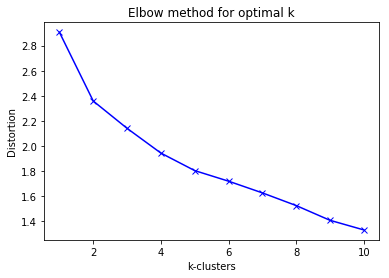

In [26]:
#Plot the elbow
plt.plot(ks, distortions, 'bx-')
plt.xlabel('k-clusters')
plt.ylabel('Distortion')
plt.title('Elbow method for optimal k')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

In [28]:
df_data.insert(1, 'Cluster Labels', kmeans.labels_)
df_data.head()

,PostalCode,Cluster Labels,Latitude,Longitude,Value,Restaurants,Markets,Bar,Cafe,asian,oriantal,american,eurpean
Neighbourhood,,,,,,,,,,,,,
Victoria Village,M4A,4,43.725882,-79.315572,3710,40,1,0,5,16,2,3,3
Regent Park,M5A,5,43.654260,-79.360636,16880,24,3,3,9,2,1,4,4
Rouge,M1B,1,43.806686,-79.194353,1260,27,2,0,10,5,4,2,4
Malvern,M1B,2,43.806686,-79.194353,4948,37,4,0,7,7,8,3,4
Highland Creek,M1C,1,43.784535,-79.160497,2403,28,4,2,8,8,7,3,2


In [29]:
# How much Neighbourhoods we have on each cluster?
df_data['Cluster Labels'].value_counts()

1    9
2    7
3    5
0    5
7    4
4    3
5    2
6    1
Name: Cluster Labels, dtype: int64

In [30]:
cluster_summary = df_data.groupby('Cluster Labels').mean().iloc[:, 2:]
cluster_summary.sort_values('Value', ascending=False)

,Value,Restaurants,Markets,Bar,Cafe,asian,oriantal,american,eurpean
Cluster Labels,,,,,,,,,
5,14869.500000,26.500000,2.000000,2.000000,6.500000,6.500000,1.000000,4.000000,2.500000
2,6071.142857,36.571429,4.142857,0.714286,5.714286,9.285714,7.285714,2.285714,2.571429
3,5931.200000,20.800000,4.000000,3.200000,14.800000,2.200000,2.600000,3.000000,4.600000
7,5796.000000,28.750000,1.250000,11.000000,12.250000,5.750000,1.250000,5.500000,6.750000
0,5134.400000,22.000000,1.800000,4.400000,9.600000,1.600000,2.000000,4.400000,4.400000
4,4208.666667,36.333333,1.000000,0.333333,4.666667,14.333333,1.666667,3.333333,2.333333
1,2865.666667,27.888889,2.333333,0.888889,7.000000,7.111111,4.555556,2.444444,3.222222
6,2856.000000,32.000000,2.000000,1.000000,8.000000,12.000000,0.000000,8.000000,1.000000


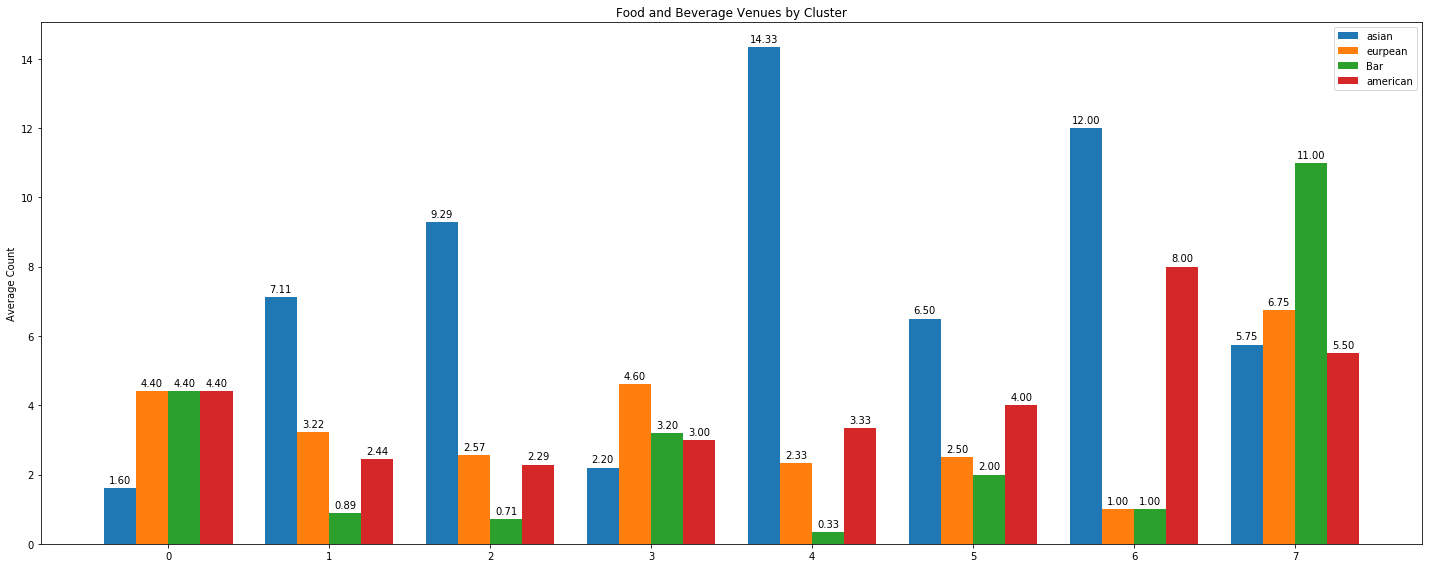

In [31]:
ind = np.arange(cluster_summary.shape[0])  # the x locations for the groups
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(20,8))
rec1 = ax.bar(ind + -3*width/2, cluster_summary['asian'], width=width, label='asian')
rec2 = ax.bar(ind + -1*width/2, cluster_summary['eurpean'], width=width, label='eurpean')
rec3 = ax.bar(ind + 1*width/2, cluster_summary['Bar'], width=width, label='Bar')
rec4 = ax.bar(ind + 3*width/2, cluster_summary['american'], width=width, label='american')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Count')
ax.set_title('Food and Beverage Venues by Cluster')
ax.set_xticks(ind)
ax.set_xticklabels(cluster_summary.index)
ax.legend()

def labels(rects, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",
                    ha=xpos, va='bottom')  # in both directions
    
for rec in [rec1, rec2, rec3, rec4]:
    labels(rec)
    
fig.tight_layout()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


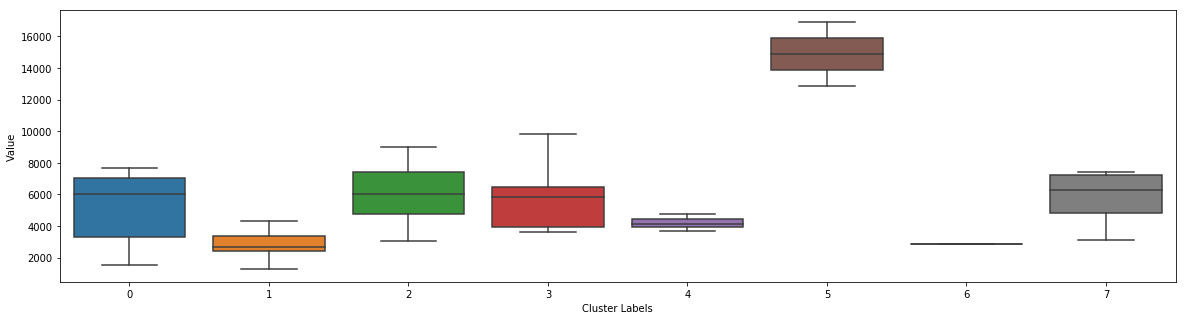

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x='Cluster Labels', y='Value', data=df_data[['Cluster Labels', 'Value']], ax=ax)

Here we can see the coorelation between the number of Food and Beverage and Family Income.
for example we can take cluster 3 that got high family income and a highest number of 

In [33]:
# Summing the Healthy venues to check correlation with HDI
df_data['F&B'] = df_data['eurpean'] + df_data['american'] + df_data['oriantal'] + df_data['asian']

# Let's check the correlation
df_data[['Value', 'F&B']].corr()

,Value,F&B
Value,1.000000,-0.190525
F&B,-0.190525,1.000000


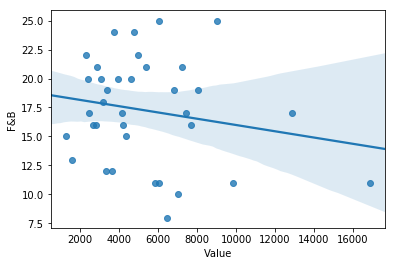

In [34]:
# Let's check how a scatterplot would look like
sns.regplot(x='Value',y='F&B', data=df_data[['Value', 'F&B']])

In [35]:
# First we define a DataFrame with those 2 clusters
potential = df_data[(df_data['Cluster Labels'] == 2) | (df_data['Cluster Labels'] == 7)].reset_index()
potential.head(2)

,Neighbourhood,PostalCode,Cluster Labels,Latitude,Longitude,Value,Restaurants,Markets,Bar,Cafe,asian,oriantal,american,eurpean,F&B
0,Malvern,M1B,2,43.806686,-79.194353,4948,37,4,0,7,7,8,3,4,22
1,Flemingdon Park,M3C,2,43.725900,-79.340923,9026,40,4,1,6,10,10,2,3,25


In [36]:
potential_map = folium.Map(location=[city_coord[0], city_coord[1]],zoom_start=12)

maplist = zip(potential['Latitude'],
              potential['Longitude'],
              potential['PostalCode'],
              potential['Neighbourhood'],
              potential['F&B'],
              potential['Value'],
              potential['Cluster Labels'])
col = {2 : 'red', 7 : 'blue'}

# add markers to map
for lat, lng, zone, name, mk, hdi, clust in maplist:
    label = '{}\n {}\n Cluster:{}\n Value:{}\n F&B:{}'.format(name, zone, clust, hdi, mk)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col[clust],
        fill=True,
        fill_color=col[clust],
        fill_opacity=0.7,
        parse_html=False).add_to(potential_map)  
    
potential_map

## Optimal Location

And now let's check the potential Neighbourhoods with the highest possible HDI and lowest possible number of Healthy Markets.
For that let's create an index: HH Index

Value Index = (Value 10 + Cafe + Restaurants) / (Bar 5 + Markets)

Basically on the denominator we are aggregating wanted features such as Gyms and Restaurants that would indicate that the Neighbourhood is health consious, while allocating weights based on importance and scale. The numerator is unwanted attributes in this case competitors.

In [37]:
# Let's create the index
potential['value index'] = (potential['Value']*10 + potential['Cafe'] + potential['Restaurants']) / ((potential['Bar']*5 + potential['Markets']) + 0.1) # Summing 0.1 to avoid divide by zero

# Let's apply a threshold for HDI, we don't want any Neighbourhood with HDI lower than 0.900
potential = potential[potential['Value'] >= 0.900]

# now sort form the highest to lowest
potential.sort_values('value index', ascending=False, inplace=True)

# And let's see the top 5 options
potential.head(5)

,Neighbourhood,PostalCode,Cluster Labels,Latitude,Longitude,Value,Restaurants,Markets,Bar,Cafe,asian,oriantal,american,eurpean,F&B,value index
3,The Beaches,M4E,2,43.676357,-79.293031,6058,43,4,0,4,11,7,3,4,25,14787.073171
0,Malvern,M1B,2,43.806686,-79.194353,4948,37,4,0,7,7,8,3,4,22,12079.024390
1,Flemingdon Park,M3C,2,43.725900,-79.340923,9026,40,4,1,6,10,10,2,3,25,9923.736264
9,Forest Hill North,M5P,2,43.696948,-79.411307,8054,34,4,1,6,10,7,1,1,19,8854.945055
10,Long Branch,M8W,2,43.602414,-79.543484,4584,35,3,1,5,13,4,1,2,20,5664.197531


In [38]:
# First let's see get the Cafe
to_cafe = to_venues[(to_venues['Neighbourhood'] == 'The Beaches') & (to_venues['Venue Category'].isin(bar))]
to_cafe


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1117,The Beaches,43.676357,-79.293031,Pinkerton Snack Bar,43.668900,-79.337309,Cocktail Bar
1188,The Beaches,43.676357,-79.293031,FUEL+,43.664399,-79.380427,Juice Bar
1196,The Beaches,43.676357,-79.293031,Greenhouse Juice Co,43.679101,-79.390686,Juice Bar


In [39]:
# Extract the gyms coordinates
cafe_coords = to_cafe[['Venue Latitude', 'Venue Longitude']].values.astype('float')
# Create th k-means object
cafe_k = KMeans(n_clusters=1).fit(cafe_coords)
# Get the centroid coordinates
cafe_center = cafe_k.cluster_centers_
cafe_center

array([[ 43.67080031, -79.3694739 ]])

In [40]:

location_map = folium.Map(location=[cafe_center[0,0], cafe_center[0,1]],zoom_start=16)

maplist = zip(to_cafe['Venue Latitude'],
              to_cafe['Venue Longitude'],
              to_cafe['Venue'],
              to_cafe['Venue Category'])

# add gym markers to map
for lat, lng, ven, cat in maplist:
    label = '{}\n {}'.format(ven, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color=col[clust],
        fill_opacity=0.7,
        parse_html=False).add_to(location_map)  
 
# add centroid markers
folium.CircleMarker(
    [cafe_center[0,0], cafe_center[0,1]],
    radius=10,
    popup='Cafe Point',
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(location_map)

    
location_map